In [1]:
import os
import csv
import torch
import numpy as np
from torch import nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.ndimage import binary_erosion
from skimage.measure import label, regionprops
from skimage.color import rgb2gray, rgba2rgb
from skimage.morphology import skeletonize
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from models import ConvNeXtTiny, SimpleUNet

def fit_ellipse(mask):
    points = np.where(skeletonize(mask))    
    # Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0
    best_a = 0.5 * (np.max(points[1]).astype(np.float32) - np.min(points[1]).astype(np.float32))
    best_b = 0.5 * (np.max(points[0]).astype(np.float32) - np.min(points[0]).astype(np.float32))
    best_x0 = np.mean(points[1]).astype(np.float32)
    best_y0 = np.mean(points[0]).astype(np.float32)
    best_theta = 0.
    best_fit = np.inf
    best_i = 0
    n_iter = 100
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    a = torch.tensor(best_a, device=device, requires_grad=True)
    b = torch.tensor(best_b, device=device, requires_grad=True)
    x0 = torch.tensor(best_x0, device=device, requires_grad=True)
    y0 = torch.tensor(best_y0, device=device, requires_grad=True)
    theta = torch.tensor(best_theta, device=device, requires_grad=True)

    x = torch.from_numpy(points[1]).to(device)
    y = torch.from_numpy(points[0]).to(device)

    optimizer = torch.optim.Adam([a, b, theta], lr=1)
    for i in range(n_iter):
        new_theta = torch.clamp(theta, - np.pi / 2, np.pi / 2)
        A = a ** 2 * torch.sin(new_theta) ** 2 + b ** 2 * torch.cos(new_theta) ** 2
        B = 2 * (b ** 2 - a ** 2) * torch.sin(new_theta) * torch.cos(new_theta) ** 2
        C = a ** 2 * torch.cos(new_theta) ** 2 + b ** 2 * torch.sin(new_theta) ** 2
        D = -2 * A * x0 - B * y0
        E = -2 * C * y0 - B * x0
        F = A * x0 ** 2 + B * x0 * y0 + C * y0 ** 2 - a ** 2 * b ** 2
        loss = torch.norm(
            A * x * x + B * x * y + C * y * y + D * x + E * y + F
        )
        loss_value = loss.detach().cpu().numpy().tolist()
        if loss_value < best_fit:
            best_fit = loss_value
            best_a = a.detach().cpu().numpy().tolist()
            best_b = b.detach().cpu().numpy().tolist()
            best_x0 = x0.detach().cpu().numpy().tolist()
            best_y0 = y0.detach().cpu().numpy().tolist()
            best_theta = new_theta.detach().cpu().numpy().tolist()
            best_i = i
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return best_a, best_b, best_x0, best_y0, best_theta


def ellipse_to_mask(a, b, theta, x0, y0, height, width):
    # Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0
    A = a ** 2 * np.sin(theta) ** 2 + b ** 2 * np.cos(theta) ** 2
    B = 2 * (b ** 2 - a ** 2) * np.sin(theta) * np.cos(theta) ** 2
    C = a ** 2 * np.cos(theta) ** 2 + b ** 2 * np.sin(theta) ** 2
    D = -2 * A * x0 - B * y0
    E = -2 * C * y0 - B * x0
    F = A * x0 ** 2 + B * x0 * y0 + C * y0 ** 2 - a ** 2 * b ** 2
    
    x, y = np.meshgrid(range(width), range(height))
    values = A * x * x + B * x * y + C * y * y + D * x + E * y + F
    return values

In [ ]:
points_path = 'Sample/Clandmarks.png'
image_path = 'Sample/Cim.png'
points_im = imread(points_path)
rgb_im = rgba2rgb(points_im)
im = rgb2gray(rgb_im)
rgb_points = rgba2rgb(points_im)
points = rgb_points[points_im[..., -1] == 1, :]
regions = np.unique(points, axis=0)
for region in regions:
    region_mask = np.prod(
        rgb_im == region.reshape(1, 3), axis=-1
    ).astype(bool)
    label_img = label(region_mask)
    region_props = regionprops(label_img)
    centroids = [prop.centroid for prop in region_props]
    print(region * 255, centroids)

In [ ]:
training_path = 'training_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'
if not os.path.exists(training_path):
    !wget -O training_set.zip https://zenodo.org/record/1327317/files/training_set.zip?download=1
    !unzip training_set.zip && rm training_set.zip

subjects = sorted([
    f for f in os.listdir(training_path)
    if f.endswith(im_suffix)
])
fig = plt.figure()
params = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for im_name in subjects:
    subject = im_name.split('.')[0]
    label_name = '{:}_Annotation.png'.format(subject) 

    im_path = os.path.join(training_path, im_name)
    im = imread(im_path)
    label_path = os.path.join(training_path, label_name)
    labels = imread(label_path)
    best_a, best_b, best_x0, best_y0, best_theta = fit_ellipse(labels > 0)

    print('Best', subject, best_a, best_b, best_x0, best_y0, best_theta)
    n_points = 1000
    angles = (np.arange(n_points) / n_points) * 2 * np.pi
    ideal_x = best_a * np.cos(angles)
    ideal_y = best_b * np.sin(angles)

    new_x = ideal_x * np.cos(best_theta) - ideal_y * np.sin(best_theta) + best_x0
    new_y = ideal_y * np.cos(best_theta) + ideal_x * np.sin(best_theta) + best_y0

    plt.scatter(new_x, new_y, s=1, c='g')
    plt.scatter(best_x0, best_y0, s=1, c='g')
    
    params.append([subject, best_a, best_b, best_x0, best_y0, best_theta])

with open(
        os.path.join(training_path, csv_name), 'w'
) as csvfile:
    evalwriter = csv.writer(csvfile)
    for param in params:
        evalwriter.writerow(param)

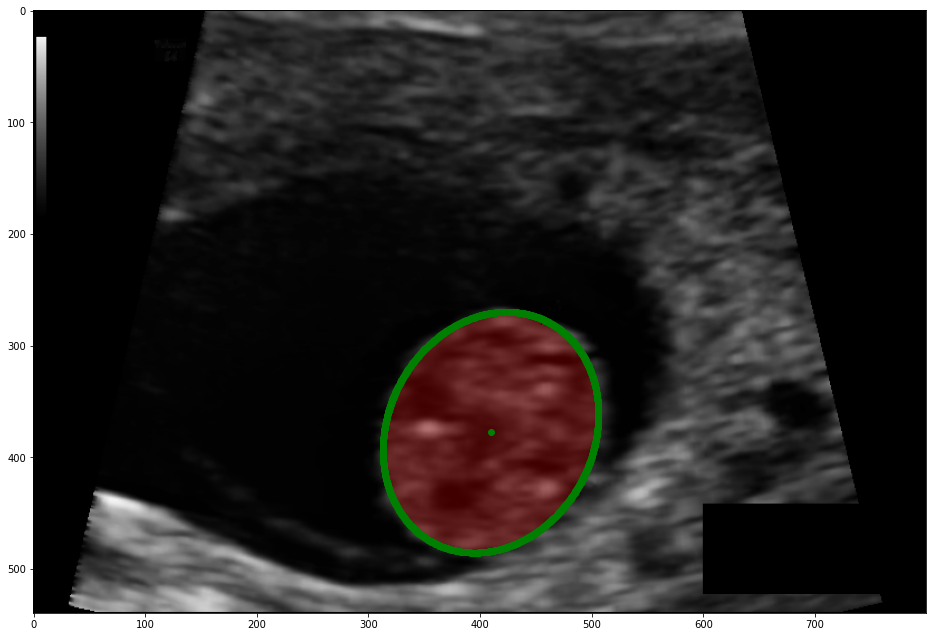

In [32]:
training_path = 'training_set/'
testing_path = 'testing_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'

height = 540
width = 800
im_size = (height, width)
half_x = im_size[1] / 2
half_y = im_size[0] / 2
angles = (np.arange(n_points) / n_points) * 2 * np.pi

fig = plt.figure(figsize=(16, 42))

class SkullUSDataset(Dataset):
    def __init__(
        self, data_path, csv_file, label_suffix='_Annotation.png',
        sub_list=None, im_size=None
    ):
        if im_size is None:
            self.im_size = (540, 800)
        else:
            self.im_size = im_size
        half_x = self.im_size[1] / 2
        half_y = self.im_size[0] / 2
        csv_path = os.path.join(data_path, csv_file)
        self.data = []
        self.labels = []
        self.params = []
        with open(csv_path, 'r') as csvfile:
            evalreader = csv.reader(csvfile)
            for subject, a, b, x0, y0, theta in evalreader:
                im_name = '{:}.png'.format(subject)
                if sub_list is None or im_name in sub_list:
                    im_path = os.path.join(
                        data_path, im_name
                    )
                    im = imread(im_path)
                    if im.shape == self.im_size:
                        self.data.append(imread(im_path))
                        label_name = subject + label_suffix
                        label_path = os.path.join(data_path, label_name)
                        self.labels.append(imread(label_path))
                        self.params.append(np.array([a, b, x0, y0, theta]))

    def __getitem__(self, index):
        image = self.data[index]
        data = np.repeat(
            np.expand_dims(image, 0), 3, axis=0
        ).astype(np.float32)
        labels = np.expand_dims(self.labels[index].astype(np.uint8), axis=0)
        params = self.params[index].astype(np.float32)

        return data, (labels, params)

    def __len__(self):
        return len(self.data)

# for im, (_, (norm_a, norm_b, norm_x0, norm_y0, true_theta)) in SkullUSDataset(training_path, csv_name)[0]:
im, (_, (true_a, true_b, true_x0, true_y0, true_theta)) = SkullUSDataset(training_path, csv_name)[0]

segmentation = ellipse_to_mask(
    true_a, true_b, true_theta, true_x0, true_y0,
    height, width
)

ideal_x = true_a * np.cos(angles)
ideal_y = true_b * np.sin(angles)
new_x = ideal_x * np.cos(true_theta) - ideal_y * np.sin(true_theta) + true_x0
new_y = ideal_y * np.cos(true_theta) + ideal_x * np.sin(true_theta) + true_y0

im_trans = np.concatenate([im, 1 - np.expand_dims(segmentation < 0, axis=0) * 0.5])

fig.clear()
plt.imshow(segmentation < 0, cmap='jet')
plt.imshow(np.moveaxis(im_trans, 0, 2), cmap='gray')
plt.scatter(new_x, new_y, c='g')
plt.scatter(true_x0, true_y0, c='g')

Network created on device cuda:0 with training losses [xentropy] and validation losses [xent, dsc, fn, fp]
< Training dataset >
< Validation dataset >
< Testing dataset >
Training / validation / test samples samples = 700 / 077 / 198 (39166145 parameters)
Epoch num |  train  |   val   |   xent   |   dsc    |    fn    |    fp    |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Epoch 008 |  0.0296 |  0.0413 |   0.0251 |   0.0162 |   0.0206 |   0.0058 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 009 |  0.0276 |  0.0424 |   0.0257 |   0.0167 |   0.0228 |   0.0051 | 47s                                                                                                                                                                               

Epoch 018 |  0.0184 |  0.0233 |   0.0142 |   0.0091 |   0.0080 |   0.0053 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
Epoch 019 |  0.0154 |  0.0204 |   0.0122 |   0.0081 |   0.0079 |   0.0043 | 48s                                                                                                                                                             

Epoch 028 |  0.0093 |  0.0146 |   0.0088 |   0.0058 |   0.0068 |   0.0024 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Epoch 029 |  0.0092 |  0.0135 |   0.0082 |   0.0054 |   0.0063 |   0.0022 | 48s                                                                                                                                                                      

454.6012282371521 270.0 340.8555641770363 0.0
456.09057545661926 270.0 298.5541681945324 0.0
467.75930523872375 270.0 204.0093219280243 0.0
489.92505073547363 270.0 287.07214437425137 0.0
493.00000071525574 270.0 370.6877741217613 0.0
411.9955748319626 270.0 315.450531989336 0.0
330.06951808929443 270.0 387.08847373723984 0.0
402.5827942416072 270.0 261.7951355315745 0.0
347.51754999160767 270.0 227.94268637895584 0.0
313.0631685256958 270.0 201.96124613285065 0.0
419.84817534685135 270.0 334.282713085413 0.0
352.00735330581665 270.0 331.0709823668003 0.0
425.23831129074097 270.0 297.90338113904 0.0
449.8412162065506 270.0 300.83068773150444 0.0
429.2205214500427 270.0 276.84616081416607 0.0
425.81433057785034 270.0 288.29965129494667 0.0
404.02346812188625 270.0 292.04776011407375 0.0
390.5515134334564 270.0 234.3896198272705 0.0
391.56604036688805 270.0 240.52441455423832 0.0
338.3781135082245 270.0 232.71226420998573 0.0
452.82525420188904 270.0 388.0557829141617 0.0
448.59853982925

Epoch 005 |  0.0370 |  0.0545 |   0.0334 |   0.0211 |   0.0250 |   0.0085 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Epoch 006 |  0.0350 |  0.0533 |   0.0326 |   0.0207 |   0.0239 |   0.0094 | 49s                                                                                                                                                                      

Epoch 015 |  0.0217 |  0.0405 |   0.0244 |   0.0161 |   0.0202 |   0.0061 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
Epoch 016 |  0.0208 |  0.0384 |   0.0234 |   0.0150 |   0.0216 |   0.0042 | 48s                                                                                                                                  

Epoch 025 |  0.0124 |  0.0209 |   0.0126 |   0.0083 |   0.0078 |   0.0046 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Epoch 026 |  0.0111 |  0.0176 |   0.0107 |   0.0069 |   0.0063 |   0.0039 | 48s                                                                                                                                                                      

400.0898437516298 270.0 256.55368085950613 0.0
428.33090126514435 270.0 273.24572746641934 0.0
406.8404234945774 270.0 279.2260744795203 0.0
419.6279600262642 270.0 285.5170290917158 0.0
391.6000060737133 270.0 263.062439057976 0.0
406.1607666313648 270.0 287.06619188189507 0.0
401.3525390997529 270.0 259.7042843699455 0.0
389.3680118024349 270.0 296.3718867301941 0.0
406.86605870723724 270.0 207.10378915071487 0.0
414.29775953292847 270.0 266.7886962555349 0.0
459.07849073410034 270.0 277.08523565903306 0.0
401.3153991661966 270.0 293.9025881141424 0.0
266.8550729751587 270.0 242.78404220938683 0.0
343.21466088294983 270.0 284.68533374369144 0.0
329.9327075481415 270.0 321.46753013134 0.0
329.9327075481415 270.0 321.46753013134 0.0
388.3047789335251 270.0 218.6758728325367 0.0
409.04910266399384 270.0 228.05836468935013 0.0
428.3759146928787 270.0 288.29461611807346 0.0
392.82031282782555 270.0 264.06747434288263 0.0
371.38021886348724 270.0 225.72083964943886 0.0
374.15280044078827 2

Epoch 002 |  0.0708 |  0.1302 |   0.0825 |   0.0477 |   0.0169 |   0.0406 | 47s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
Epoch 003 |  0.0576 |  0.0729 |   0.0456 |   0.0273 |   0.0157 |   0.0208 | 47s                                                                                                                                           

Epoch 012 |  0.0253 |  0.0441 |   0.0264 |   0.0177 |   0.0103 |   0.0121 | 47s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 013 |  0.0240 |  0.0409 |   0.0245 |   0.0164 |   0.0189 |   0.0065 | 47s                                                                                                                                                                               

Epoch 022 |  0.0144 |  0.0233 |   0.0140 |   0.0093 |   0.0112 |   0.0037 | 47s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 023 |  0.0144 |  0.0233 |   0.0141 |   0.0092 |   0.0057 |   0.0063 | 47s                                                                                                                                                                               

406.3036806881428 270.0 238.29690501093864 0.0
393.895385786891 270.0 300.581574216485 0.0
419.3949580192566 270.0 282.2361758351326 0.0
453.8736879825592 270.0 264.3324583210051 0.0
399.34234619140625 270.0 287.24526956677437 0.0
387.0780646800995 270.0 291.95785515010357 0.0
371.29153311252594 270.0 288.7492364645004 0.0
251.49357318878174 270.0 284.57467652857304 0.0
363.36889564991 270.0 274.18597407639027 0.0
414.0993043780327 270.0 319.04760763049126 0.0
368.0470883846283 270.0 253.44772305339575 0.0
401.6375731676817 270.0 274.043640056625 0.0
322.33468890190125 270.0 272.61508187279105 0.0
385.40701270103455 270.0 287.3545226454735 0.0
396.41693122684956 270.0 300.6038211286068 0.0
389.8992918431759 270.0 282.7349852398038 0.0
343.82196068763733 270.0 211.19372472167015 0.0
322.6112365722656 270.0 270.02233886683825 0.0
490.858519077301 270.0 281.83853164315224 0.0
400.3452758770436 270.0 270.31118774204515 0.0
381.16406202316284 270.0 264.79318253695965 0.0
411.03579699993134 

Epoch 000 |  0.2540 |  0.2647 |   0.1653 |   0.0993 |   0.1421 |   0.0167 | 44s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Epoch 001 |  0.1189 |  0.1616 |   0.1053 |   0.0563 |   0.0710 |   0.0167 | 47s                                                                                                                                                                                        

Epoch 010 |  0.0294 |  0.0526 |   0.0316 |   0.0210 |   0.0253 |   0.0083 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
Epoch 011 |  0.0297 |  0.0471 |   0.0283 |   0.0188 |   0.0172 |   0.0098 | 48s                                                                                                                                           

Epoch 020 |  0.0189 |  0.0309 |   0.0186 |   0.0123 |   0.0144 |   0.0049 | 48s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Epoch 021 |  0.0171 |  0.0295 |   0.0178 |   0.0116 |   0.0171 |   0.0032 | 48s                                                                                                                                                                      

330.0858438014984 270.0 296.90255776047707 0.0
447.80923426151276 270.0 258.8707584142685 0.0
400.2833862323314 270.0 206.8264178931713 0.0
378.0326843261719 270.0 307.4895331263542 0.0
355.60229420661926 270.0 238.43193143606186 0.0
386.58785969018936 270.0 227.45697185397148 0.0
454.00949120521545 270.0 247.5731210410595 0.0
367.3112481832504 270.0 270.56781004881486 0.0
369.0062552690506 270.0 269.0242004371248 0.0
355.2826225757599 270.0 281.64492778480053 0.0
382.9180911183357 270.0 275.32327277585864 0.0
409.1462403535843 270.0 278.49801667034626 0.0
386.1969903111458 270.0 252.69807413220406 0.0
392.04336553812027 270.0 256.8265077844262 0.0
368.14538538455963 270.0 283.144439868629 0.0
403.05429082363844 270.0 247.51426599919796 0.0
404.3065492063761 270.0 270.7730712695047 0.0
418.18478405475616 270.0 293.2274177670479 0.0
376.40954554080963 270.0 308.179289996624 0.0
404.1025694459677 270.0 300.6385201960802 0.0
352.00427174568176 270.0 206.06138482689857 0.0
411.653320491313

363.09637427330017 270.0 347.9956018924713 0.0
413.31442296504974 270.0 276.3630674779415 0.0
440.0438219308853 270.0 237.03614741563797 0.0
405.3560484200716 270.0 292.7727350592613 0.0
373.59661757946014 270.0 324.485075622797 0.0
337.2401714324951 270.0 240.83567820489407 0.0
428.60052585601807 270.0 246.0634309798479 0.0
354.30972278118134 270.0 309.2257095873356 0.0
385.29312163591385 270.0 262.12823471054435 0.0
391.3036495447159 270.0 281.45281959325075 0.0
389.5386353135109 270.0 254.0645905584097 0.0
414.5660400390625 270.0 281.8406680226326 0.0
406.34817481040955 270.0 313.8289475440979 0.0
388.64389061927795 270.0 272.9339294694364 0.0
Network created on device cuda:0 with training losses [xentropy] and validation losses [xent, dsc, fn, fp]
< Training dataset >
< Validation dataset >
< Testing dataset >
Training / validation / test samples samples = 700 / 079 / 196 (39166145 parameters)
Epoch num |  train  |   val   |   xent   |   dsc    |    fn    |    fp    |              

Epoch 008 |  0.0288 |  0.0502 |   0.0240 |   0.0261 |   0.0286 |   0.0056 | 47s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 009 |  0.0269 |  0.0517 |   0.0249 |   0.0267 |   0.0177 |   0.0092 | 47s                                                                                                                                                                               

Epoch 018 |  0.0163 |  0.0312 |   0.0149 |   0.0162 |   0.0228 |   0.0028 | 47s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Epoch 019 |  0.0167 |  0.0294 |   0.0136 |   0.0157 |   0.0186 |   0.0032 | 47s                                                                                                                                                                      

Epoch 028 |  0.0101 |  0.0185 |   0.0086 |   0.0100 |   0.0096 |   0.0021 | 47s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Epoch 029 |  0.0095 |  0.0203 |   0.0091 |   0.0113 |   0.0121 |   0.0026 | 47s                                                                                                                                                                      

402.78323367238045 270.0 255.25460824370384 0.0
386.3018795847893 270.0 253.50857567042112 0.0
399.7629089280963 270.0 261.8599244579673 0.0
413.188873231411 270.0 307.43417233228683 0.0
434.2195749282837 270.0 298.35525557398796 0.0
399.6521606342867 270.0 261.9163207523525 0.0
400.6112365517765 270.0 287.5288085639477 0.0
376.7525941133499 270.0 285.6959840655327 0.0
351.89239382743835 270.0 255.79530335962772 0.0
382.3442071676254 270.0 218.3631607890129 0.0
384.55764800310135 270.0 267.09277351386845 0.0
394.9806824326515 270.0 299.12356562912464 0.0
409.9714048206806 270.0 255.1000828295946 0.0
356.107422709465 270.0 267.1266480535269 0.0
398.31906128674746 270.0 258.2596130669117 0.0
383.7827458977699 270.0 278.10778794810176 0.0
381.8890690803528 270.0 244.28485080599785 0.0
403.8333434611559 270.0 306.6702899336815 0.0
355.9751272201538 270.0 282.0760801434517 0.0
383.57586711645126 270.0 270.92279052129015 0.0
428.7972420454025 270.0 223.2392880320549 0.0
372.188264131546 270.

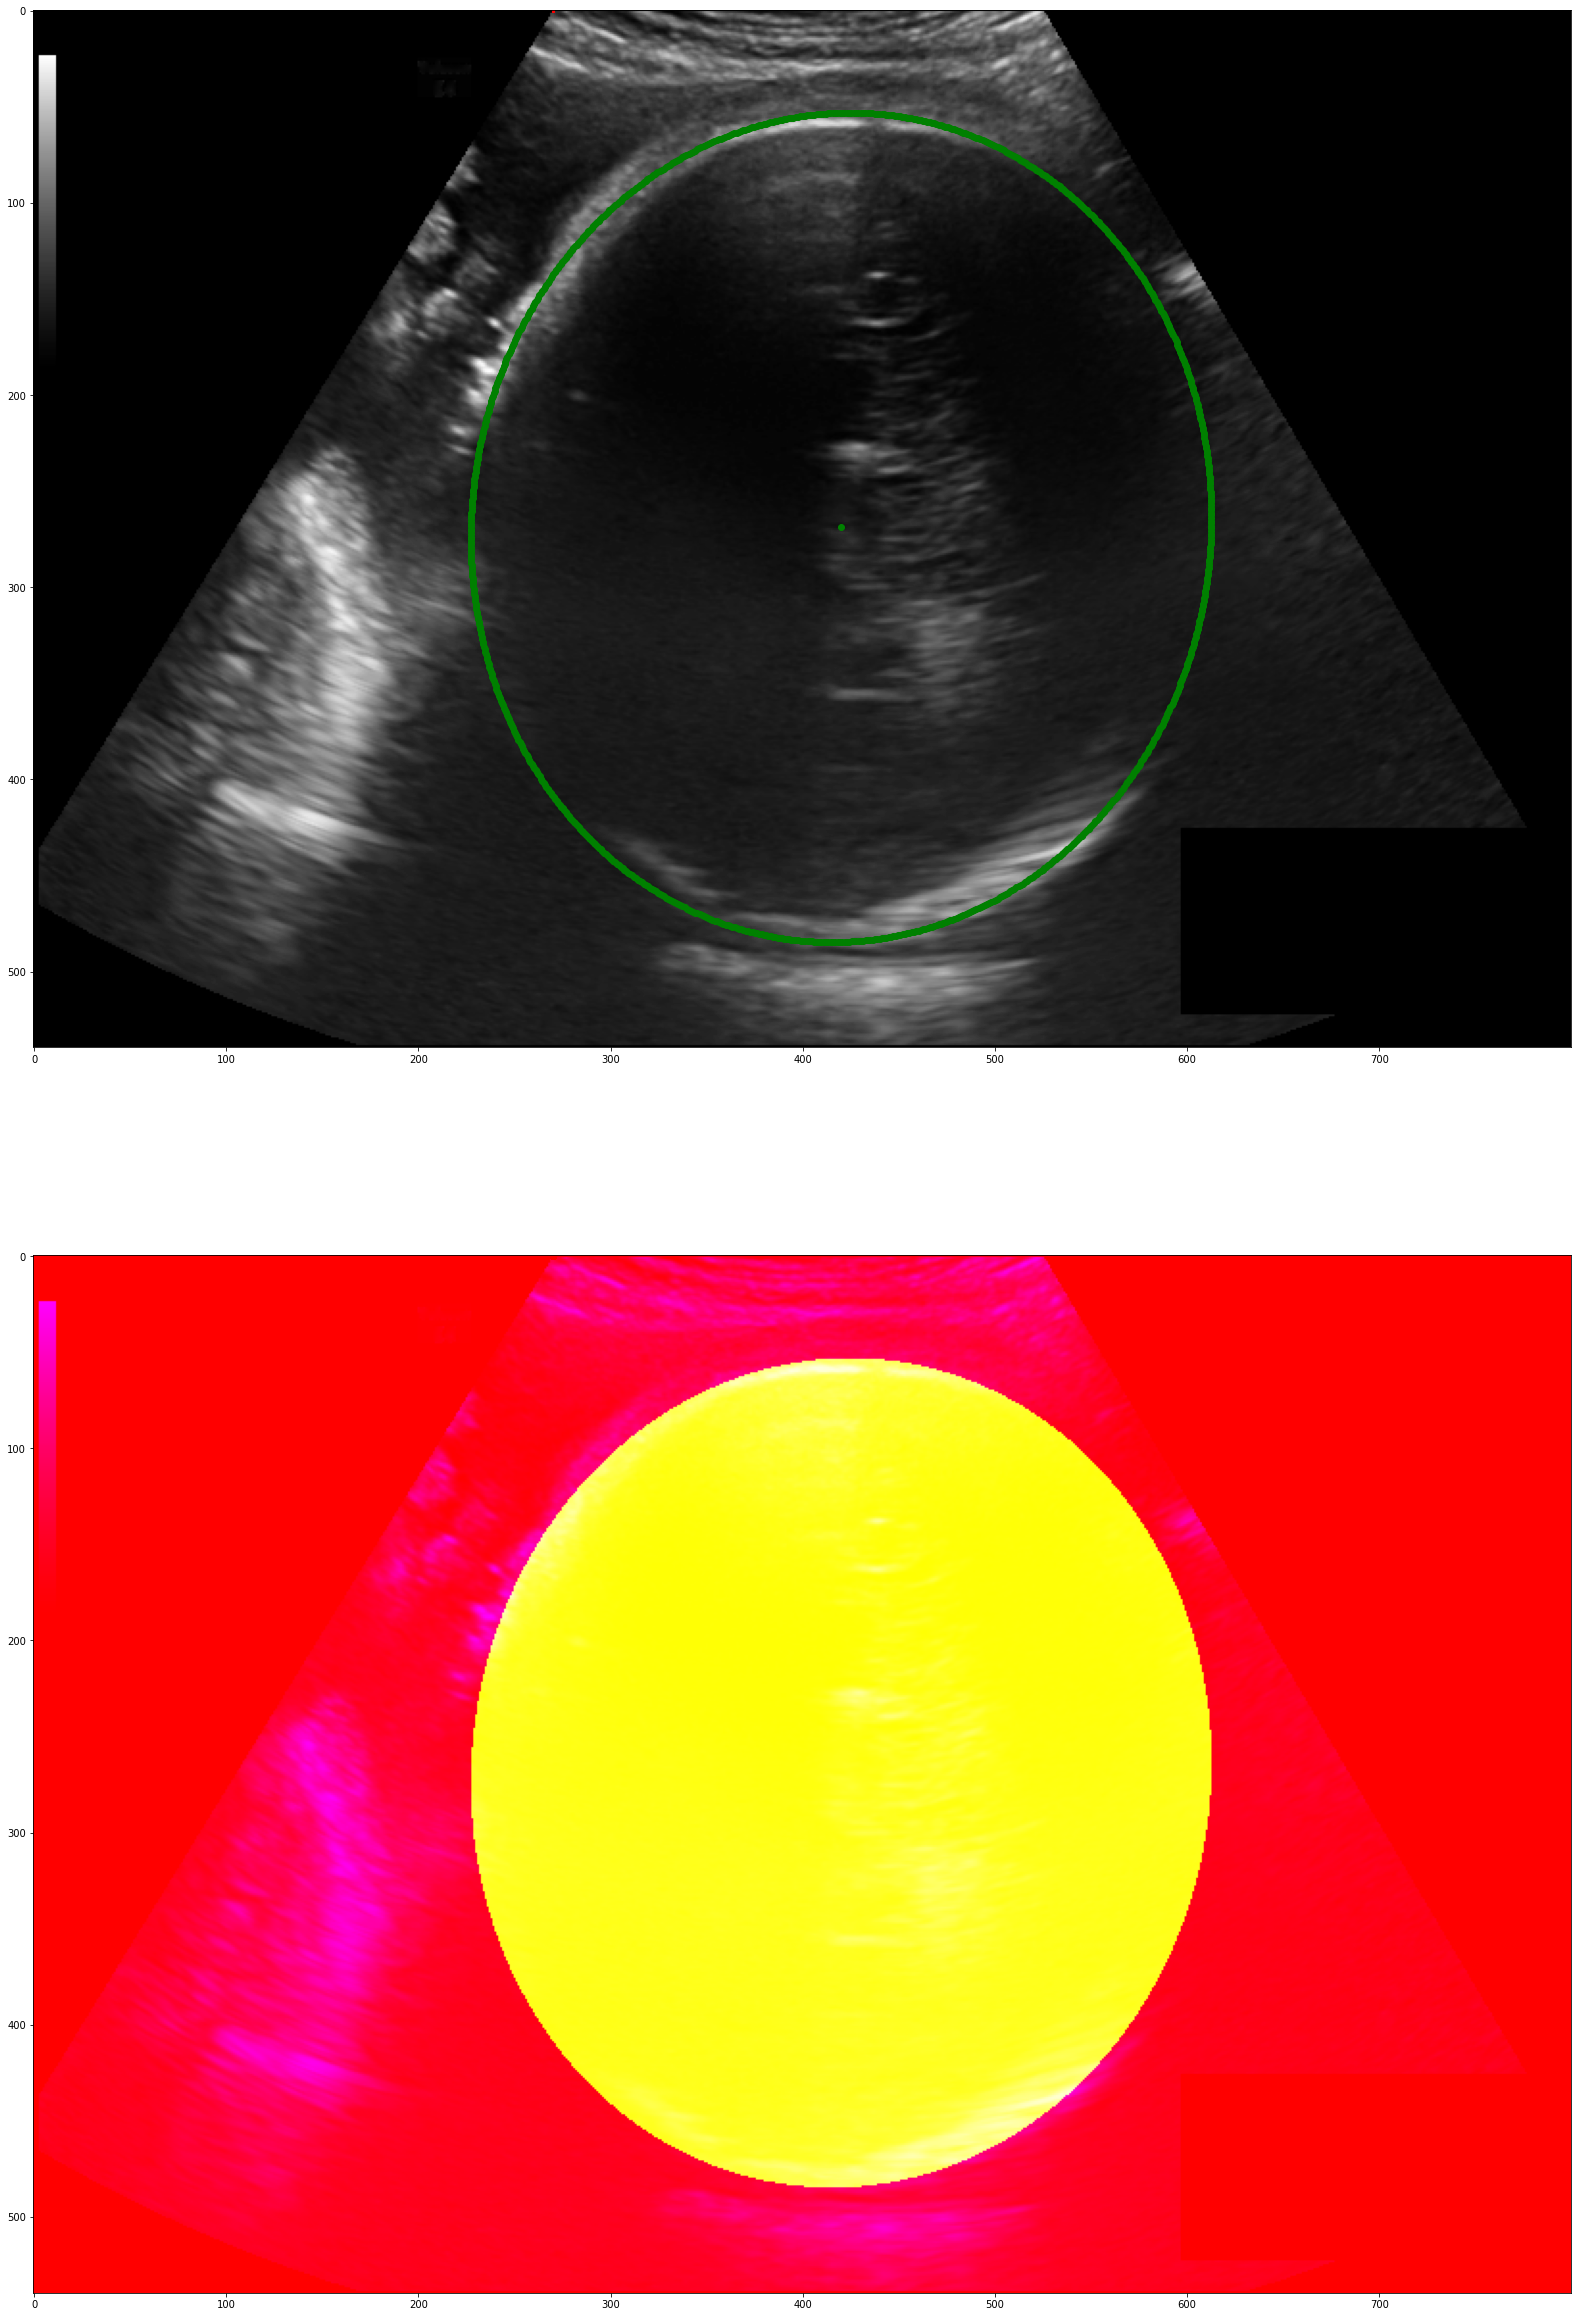

In [3]:
training_path = 'training_set/'
testing_path = 'testing_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'
n_folds = 5
val_split = 0.1
train_size = 8
test_size = 8
epochs = 30
patience = 10
subjects = sorted([
    f for f in os.listdir(training_path)
    if f.endswith(im_suffix)
])

im_size = (540, 800)
half_x = im_size[1] / 2
half_y = im_size[0] / 2

n_points = 1000
angles = (np.arange(n_points) / n_points) * 2 * np.pi

class SkullUSDataset(Dataset):
    def __init__(
        self, data_path, csv_file, label_suffix='_Annotation.png',
        sub_list=None, im_size=None
    ):
        if im_size is None:
            self.im_size = (540, 800)
        else:
            self.im_size = im_size
        half_x = self.im_size[1] / 2
        half_y = self.im_size[0] / 2
        csv_path = os.path.join(data_path, csv_file)
        self.data = []
        self.labels = []
        self.params = []
        with open(csv_path, 'r') as csvfile:
            evalreader = csv.reader(csvfile)
            for subject, a, b, x0, y0, theta in evalreader:
                im_name = '{:}.png'.format(subject)
                if sub_list is None or im_name in sub_list:
                    im_path = os.path.join(
                        data_path, im_name
                    )
                    im = imread(im_path)
                    if im.shape == self.im_size:
                        self.data.append(imread(im_path))
                        label_name = subject + label_suffix
                        label_path = os.path.join(data_path, label_name)
#                         self.labels.append(imread(label_path))
                        self.labels.append(
                            ellipse_to_mask(
                                float(a), float(b), float(theta),
                                float(x0), float(y0),
                                self.im_size[0], self.im_size[1]
                            ) < 0
                        )
                        norm_a = (float(a) - half_x) / half_x
                        norm_b = (float(b) - half_y) / half_y
                        norm_x0 = (float(x0) - half_x) / half_x
                        norm_y0 = (float(y0) - half_y) / half_y
                        norm_theta = float(theta)
                        self.params.append(np.array([
                            norm_a, norm_b, norm_x0, norm_y0, norm_theta
                        ]))

    def __getitem__(self, index):
        image = self.data[index]
        image_norm = (image - image.mean()) / image.std()
        data = np.repeat(
            np.expand_dims(image_norm, 0), 3, axis=0
        ).astype(np.float32)
        labels = np.expand_dims(self.labels[index].astype(np.float32), axis=0)
        params = self.params[index].astype(np.float32)

        return data, (labels, params)

    def __len__(self):
        return len(self.data)

fig = plt.figure(figsize=(32, 42))

for i in range(n_folds):
    fold_ini = len(subjects) * i // n_folds
    fold_end = len(subjects) * (i + 1) // n_folds
    
    training_set = subjects[fold_end:] + subjects[:fold_ini]

    # We account for a validation set or the lack of it. The reason for
    # this is that we want to measure forgetting and that is easier to
    # measure if we only focus on the training set and leave the testing
    # set as an independent generalisation test.
    if val_split > 0:
        n_training = int(len(training_set))
        training_set = training_set[int(n_training * val_split):]
        validation_set = training_set[:int(n_training * val_split)]
    else:
        validation_set = training_set
        
    # Testing set for the current fold
    testing_set = subjects[fold_ini:fold_end]
    
    net = SimpleUNet()
    
    print('< Training dataset >')
    train_dataset = SkullUSDataset(training_path, csv_name, sub_list=training_set)
    train_loader = DataLoader(
        train_dataset, train_size, True, num_workers=1
    )
    
    print('< Validation dataset >')
    val_dataset = SkullUSDataset(training_path, csv_name, sub_list=validation_set)
    val_loader = DataLoader(
        val_dataset, test_size, num_workers=1
    )
    
    print('< Testing dataset >')
    test_dataset = SkullUSDataset(training_path, csv_name, sub_list=testing_set)
    test_loader = DataLoader(
        test_dataset, test_size, num_workers=1
    )
    
    print(
        'Training / validation / test samples samples = '
        '{:03d} / {:03d} / {:03d} ({:d} parameters)'.format(
            len(train_dataset), len(val_dataset), len(test_dataset),
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )

    net.fit(
        train_loader, val_loader, epochs=epochs, patience=patience
    )
    
    net.eval()
    batch_j = 0
    for im, (true, params) in test_loader:
        with torch.no_grad():
            pred = torch.sigmoid(net(im.to(net.device))).detach().cpu()
        for norm_p, gt, seg, im_j in zip(params.numpy(), true, pred, im):
            brain_mask = seg.numpy() > 0
            inner_brain = binary_erosion(brain_mask)
            outer_brain = torch.from_numpy(
                np.logical_and(
                    brain_mask, np.logical_not(inner_brain)
                )
            )
            pred_a, pred_b, pred_x0, pred_y0, pred_theta = fit_ellipse(outer_brain)
            norm_a, norm_b, norm_x0, norm_y0, true_theta = norm_p
            true_a = norm_a * half_x + half_x
            true_b = norm_b * half_y + half_y
            true_x0 = norm_x0 * half_x + half_x
            true_y0 = norm_y0 * half_y + half_y
            print(true_x0, pred_x0, true_y0, pred_y0)
            fig.clear()
            plt.subplot(2, 1, 1)
            plt.imshow(im_j[0, ...], cmap='gray')
            ideal_x = true_a * np.cos(angles)
            ideal_y = true_b * np.sin(angles)
            new_x = ideal_x * np.cos(true_theta) - ideal_y * np.sin(true_theta) + true_x0
            new_y = ideal_y * np.cos(true_theta) + ideal_x * np.sin(true_theta) + true_y0
            plt.scatter(new_x, new_y, c='g')
            plt.scatter(true_x0, true_y0, c='g')
            
            ideal_x = pred_a * np.cos(angles)
            ideal_y = pred_b * np.sin(angles)

            new_x = ideal_x * np.cos(pred_theta) - ideal_y * np.sin(pred_theta) + pred_x0
            new_y = ideal_y * np.cos(pred_theta) + ideal_x * np.sin(pred_theta) + pred_y0

            plt.scatter(new_x, new_y, s=1, c='r')
            plt.scatter(pred_x0, pred_y0, s=1, c='r')
            plt.subplot(2, 1, 2)
            norm_im = (im_j[:1, ...] - torch.min(im_j)) / (torch.max(im_j) - torch.min(im_j))
            segmentation = np.moveaxis(
                torch.cat([outer_brain, gt, norm_im]).detach().cpu().numpy(), 0, -1
            )
            plt.imshow(segmentation)
            
            plt.scatter(new_x, new_y, c='r')
            plt.scatter(pred_x0, pred_y0, c='r')
            plt.savefig(
                os.path.join(
                    testing_path,
                    'unet_f{:02d}_b{:02d}.png'.format(i, batch_j)
                )
            )

            batch_j += 1